In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [5]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


UniProt ID: Q48658


In [76]:
def find_k_nearest_neighbors_for_one(phi_psi_dist, preds, k=10):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]
    phi_psi_dist = phi_psi_dist.values
    pred = np.concatenate([preds['phi'].values, preds['psi'].values])

    # Calculate the distances
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    distances = np.sqrt(np.sum((diff(pred, phi_psi_dist))**2, axis=1))

    nearest = np.argsort(distances)[:k]
    return phi_psi_dist[nearest], distances[nearest]

# nearest, distances = find_k_nearest_neighbors(phi_psi_dist, xrays, k=10)

In [77]:
def find_k_nearest_neighbors(phi_psi_dist, preds, k=10):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]

    preds = preds[['protein_id', 'pos', 'phi', 'psi']].pivot(index='protein_id', columns='pos', values=['phi', 'psi'])
    preds.columns = [f'{c[0]}_{c[1]}' for c in preds.columns.to_flat_index()]

    phi_psi_dist = phi_psi_dist.values
    preds = preds.values

    # Calculate the distance matrix
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    
    distances = np.linalg.norm(diff(preds[:,np.newaxis], phi_psi_dist), axis=2)
    nearest = np.argsort(distances, axis=1)[:, :k]
    return distances[np.arange(distances.shape[0])[:, np.newaxis], nearest]

In [78]:
def find_neighbors_in_threshold_for_one(phi_psi_dist, preds, threshold=30):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]
    phi_psi_dist = phi_psi_dist.values
    pred = np.concatenate([preds['phi'].values, preds['psi'].values])

    # Calculate the distances
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    distances = np.sqrt(np.sum((diff(pred, phi_psi_dist))**2, axis=1))
    return (distances < threshold).sum()

# nearest, distances = find_k_nearest_neighbors(phi_psi_dist, xrays, k=10)
def find_neighbors_in_threshold(phi_psi_dist, preds, threshold=30):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]

    preds = preds[['protein_id', 'pos', 'phi', 'psi']].pivot(index='protein_id', columns='pos', values=['phi', 'psi'])
    preds.columns = [f'{c[0]}_{c[1]}' for c in preds.columns.to_flat_index()]

    phi_psi_dist = phi_psi_dist.values
    preds = preds.values

    # Calculate the distance matrix
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    
    distances = np.linalg.norm(diff(preds[:,np.newaxis], phi_psi_dist), axis=2)
    return (distances < threshold).sum(axis=1)

In [79]:
def calc_score(ins, thresholds):
    # ins is dihedral adherence object
    # q is the query object for a window size
    ins.phi_psi_predictions['new_score'] = np.nan
    ins.xray_phi_psi['new_score'] = np.nan

    center_idx_ctxt = ins.queries[-1].get_center_idx()
    winsize_ctxt = ins.queries[-1].winsize
    if center_idx_ctxt < 0:
        center_idx_ctxt = winsize_ctxt + center_idx_ctxt
    for i,seq_ctxt in enumerate(ins.xray_phi_psi.seq_ctxt[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]):
        print(f'{i}/{ins.xray_phi_psi.shape[0] - winsize_ctxt}', seq_ctxt)

        pred_scores_qs = []
        xray_score_qs = []
        n_queries = 1
        for q,t in zip(ins.queries[:n_queries], thresholds[:n_queries]):
            seq = q.get_subseq(seq_ctxt)
            phi_psi_dist = q.results_window[q.results_window['seq'] == seq]
            if phi_psi_dist.shape[0] < t:
                print('\tSkipping', seq, 'Not enough data')
                continue

            center_idx = q.get_center_idx()
            if center_idx < 0:
                center_idx = q.winsize + center_idx
            
            xray_pos = ins.xray_phi_psi[ins.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
            xrays = ins.xray_phi_psi[(ins.xray_phi_psi.pos >= xray_pos-center_idx) & (ins.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)]

            pred_pos = ins.phi_psi_predictions[ins.phi_psi_predictions.seq_ctxt == seq_ctxt].pos.unique()
            if len(pred_pos) == 0:
                print('\tSkipping', seq_ctxt, 'Prediction Positions are not unique')
                continue
            pred_pos = pred_pos[0]
            preds = ins.phi_psi_predictions[(ins.phi_psi_predictions.pos >= pred_pos-center_idx) & (ins.phi_psi_predictions.pos < pred_pos-center_idx+q.winsize)]

            if xrays.shape[0] < q.winsize or preds.shape[0] % q.winsize != 0:
                print('\tSkipping', seq_ctxt, 'Not enough xray or prediction data')
                continue
            pred_scores = find_neighbors_in_threshold(phi_psi_dist, preds, t)
            pred_scores_qs.append(pred_scores / (phi_psi_dist.shape[0] // q.winsize))

            xray_score = find_neighbors_in_threshold_for_one(phi_psi_dist, xrays, t)
            xray_score_qs.append(xray_score / (phi_psi_dist.shape[0] // q.winsize))

            print('\t', seq, q.winsize, phi_psi_dist.shape[0] // q.winsize)
            print(f'\tPredictions: {pred_scores.mean():.2f}+-{pred_scores.std():.2f} -> Normalized: {pred_scores_qs[-1].mean():.2f}+-{pred_scores_qs[-1].std():.2f}')
            print(f'\tXray: {xray_score:.2f} -> Normalized: {xray_score_qs[-1]:.2f}')

        # For now, only use first two queries
        if len(pred_scores_qs) < n_queries:
            print('Skipping', seq_ctxt, 'Missing data for window sizes')
            continue
        pred_scores = np.stack(pred_scores_qs)
        xrays = np.array(xray_score_qs)

        pred_scores = np.mean(pred_scores, axis=0)
        xray_score = np.mean(xrays)

        ins.phi_psi_predictions.loc[ins.phi_psi_predictions.seq_ctxt == seq_ctxt, 'new_score'] = pred_scores
        ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq_ctxt, 'new_score'] = xray_score
thresholds = [15, 5, 2, 2]
calc_score(da, thresholds)

0/366 WNLDKNL
	 LDKN 4 2427
	Predictions: 1.14+-5.13 -> Normalized: 0.00+-0.00
	Xray: 0.00 -> Normalized: 0.00
1/366 NLDKNLQ
	 DKNL 4 3165
	Predictions: 4.50+-17.90 -> Normalized: 0.00+-0.01
	Xray: 0.00 -> Normalized: 0.00
2/366 LDKNLQL
	 KNLQ 4 2662
	Predictions: 85.45+-127.34 -> Normalized: 0.03+-0.05
	Xray: 20.00 -> Normalized: 0.01
3/366 DKNLQLR
	 NLQL 4 1602
	Predictions: 25.75+-25.37 -> Normalized: 0.02+-0.02
	Xray: 74.00 -> Normalized: 0.05
4/366 KNLQLRL
	 LQLR 4 2892
	Predictions: 121.43+-120.43 -> Normalized: 0.04+-0.04
	Xray: 226.00 -> Normalized: 0.08
5/366 NLQLRLG
	 QLRL 4 2633
	Predictions: 123.76+-107.03 -> Normalized: 0.05+-0.04
	Xray: 253.00 -> Normalized: 0.10
6/366 LQLRLGI
	 LRLG 4 4454
	Predictions: 107.14+-99.36 -> Normalized: 0.02+-0.02
	Xray: 95.00 -> Normalized: 0.02
7/366 QLRLGIV
	 RLGI 4 4135
	Predictions: 110.81+-105.33 -> Normalized: 0.03+-0.03
	Xray: 56.00 -> Normalized: 0.01
8/366 LRLGIVF
	 LGIV 4 3126
	Predictions: 200.38+-154.75 -> Normalized: 0.06+-0.05


LGAFSYG
1390


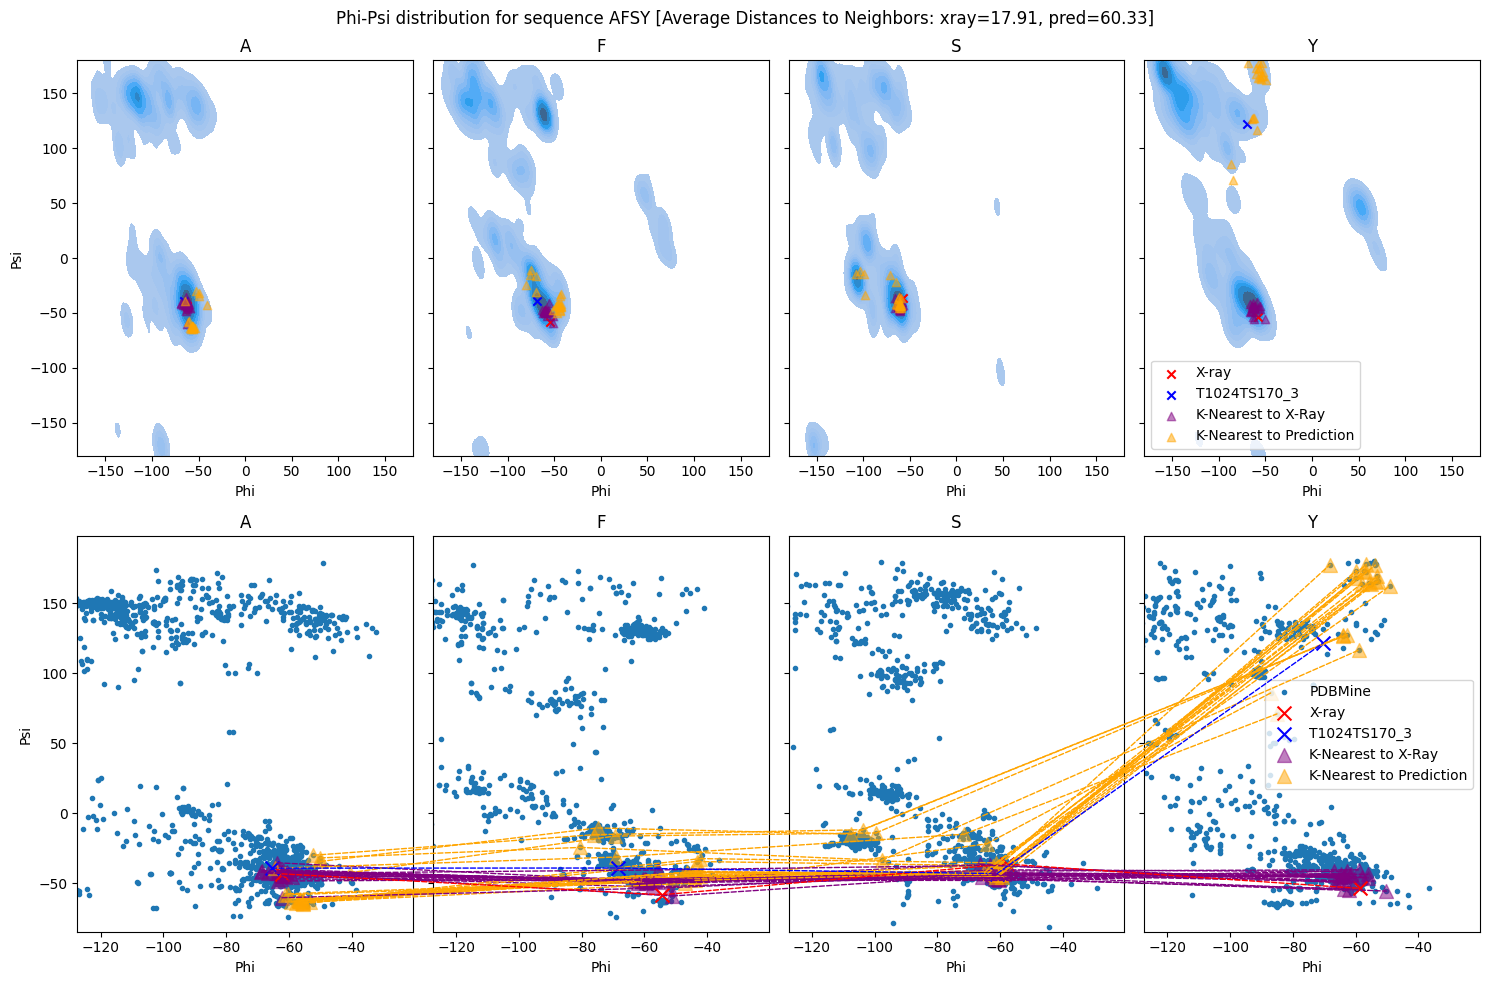

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch

def plot(ins, q, seq_ctxt, protein_id, k):
    # seq_ctxt = 'TFVMTET'
    print(seq_ctxt)
    seq = q.get_subseq(seq_ctxt)

    center_idx = q.get_center_idx()
    if center_idx < 0:
        center_idx = q.winsize + center_idx
    xray_pos = ins.xray_phi_psi[ins.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
    xrays = ins.xray_phi_psi[(ins.xray_phi_psi.pos >= xray_pos-center_idx) & (ins.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)]

    pred_mask = ins.phi_psi_predictions.protein_id == protein_id
    pred_pos = ins.phi_psi_predictions[(ins.phi_psi_predictions.seq_ctxt == seq_ctxt) & pred_mask].pos.iloc[0]
    preds = ins.phi_psi_predictions[pred_mask & ((ins.phi_psi_predictions.pos >= pred_pos-center_idx) & (ins.phi_psi_predictions.pos < pred_pos-center_idx+q.winsize))]
    fig, axes = plt.subplots(2, q.winsize, figsize=(15, 10), sharey='row')

    df = q.results_window[q.results_window['seq'] == seq]
    print(df.shape[0] // q.winsize)
    nearest, distances = find_k_nearest_neighbors_for_one(df, xrays, k=k)
    # average_nearest = np.stack(np.split(nearest.mean(axis=0), 2)).T
    nearest = np.stack([nearest[:, :q.winsize], nearest[:, q.winsize:]]).transpose(1,2,0)

    pred_nearest, pred_distances = find_k_nearest_neighbors_for_one(df, preds, k=k)
    pred_nearest = np.stack([pred_nearest[:, :q.winsize], pred_nearest[:, q.winsize:]]).transpose(1,2,0)

    for i, ax in enumerate(axes[0]):
        dist = df[df['window_pos'] == i]
        if q.winsize > 4:
            ax.scatter(dist.phi, dist.psi, marker='.', label='PDBMine')
        else:
            sns.kdeplot(data=dist, x='phi', y='psi', label='PDBMine', ax=ax, fill=True, bw_method=0.1)
        ax.scatter(xrays.iloc[i].phi, xrays.iloc[i].psi, marker='x', color='red', label='X-ray')
        # ax.scatter(afs.iloc[i].phi, afs.iloc[i].psi, marker='x', color='purple')
        ax.scatter(preds.iloc[i].phi, preds.iloc[i].psi, marker='x', color='blue', label=protein_id)
        ax.scatter(nearest[:, i, 0], nearest[:, i, 1], marker='^', color='purple', label='K-Nearest to X-Ray', alpha=0.5)
        ax.scatter(pred_nearest[:, i, 0], pred_nearest[:, i, 1], marker='^', color='orange', label='K-Nearest to Prediction', alpha=0.5)
        ax.set_xlim(-180, 180)
        ax.set_ylim(-180, 180)
        ax.title.set_text(dist.iloc[0].res)
        ax.set_xlabel('Phi')
        if i == 0:
            ax.set_ylabel('Psi')
        if i == len(axes[0])-1:
            ax.legend()

    xmax = max(xrays.phi.max(), preds.phi.max(), nearest[:, :, 0].max(), pred_nearest[:, :, 0].max()) + 20
    ymax = max(xrays.psi.max(), preds.psi.max(), nearest[:, :, 1].max(), pred_nearest[:, :, 1].max()) + 20
    xmin = min(xrays.phi.min(), preds.phi.min(), nearest[:, :, 0].min(), pred_nearest[:, :, 0].min()) - 20
    ymin = min(xrays.psi.min(), preds.psi.min(), nearest[:, :, 1].min(), pred_nearest[:, :, 1].min()) - 20
    for i, ax in enumerate(axes[1]):
        dist = df[df['window_pos'] == i]
        ax.scatter(dist.phi, dist.psi, marker='.', label='PDBMine')
        # sns.kdeplot(data=dist, x='phi', y='psi', label='PDBMine', ax=ax, fill=True, bw_method=0.1)
        ax.scatter(xrays.iloc[i].phi, xrays.iloc[i].psi, marker='x', color='red', label='X-ray', s=100, zorder=100)
        ax.scatter(preds.iloc[i].phi, preds.iloc[i].psi, marker='x', color='blue', label=protein_id, s=100, zorder=100)
        ax.scatter(nearest[:, i, 0], nearest[:, i, 1], marker='^', color='purple', label='K-Nearest to X-Ray', alpha=0.5, s=100)
        # ax.scatter(average_nearest[i, 0], average_nearest[i, 1], marker='o', color='orange', label='Average Nearest')
        ax.scatter(pred_nearest[:, i, 0], pred_nearest[:, i, 1], marker='^', color='orange', label='K-Nearest to Prediction', alpha=0.5, s=100)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.title.set_text(dist.iloc[0].res)
        ax.set_xlabel('Phi')
        if i == 0:
            ax.set_ylabel('Psi')
        if i == len(axes[0])-1:
            ax.legend()
    def add_conn(i, xyA, xyB, color):
        con = ConnectionPatch(
            xyA=xyA, 
            xyB=xyB, 
            coordsA="data", coordsB="data", 
            axesA=axes[1,i], axesB=axes[1,i+1], 
            color=color, lw=1, linestyle='--'
        )
        fig.add_artist(con)
    # draw lines
    for i in range(q.winsize-1):
        for j in range(nearest.shape[0]):
            add_conn(i, (nearest[j, i, 0], nearest[j, i, 1]), (nearest[j, i+1, 0], nearest[j, i+1, 1]), 'purple')
            add_conn(i, (pred_nearest[j, i, 0], pred_nearest[j, i, 1]), (pred_nearest[j, i+1, 0], pred_nearest[j, i+1, 1]), 'orange')
        add_conn(i, (xrays.iloc[i].phi, xrays.iloc[i].psi), (xrays.iloc[i+1].phi, xrays.iloc[i+1].psi), 'red')
        add_conn(i, (preds.iloc[i].phi, preds.iloc[i].psi), (preds.iloc[i+1].phi, preds.iloc[i+1].psi), 'blue')

    plt.suptitle(f'Phi-Psi distribution for sequence {seq} [Average Distances to Neighbors: xray={np.mean(distances):.2f}, pred={np.mean(pred_distances):.2f}]')
    plt.tight_layout()
    plt.show()

    return xrays, preds, nearest, pred_nearest, distances, pred_distances

seq_ctxt = da.xray_phi_psi.iloc[18].seq_ctxt
plot(da, da.queries[0], seq_ctxt, da.protein_ids[2], 20);

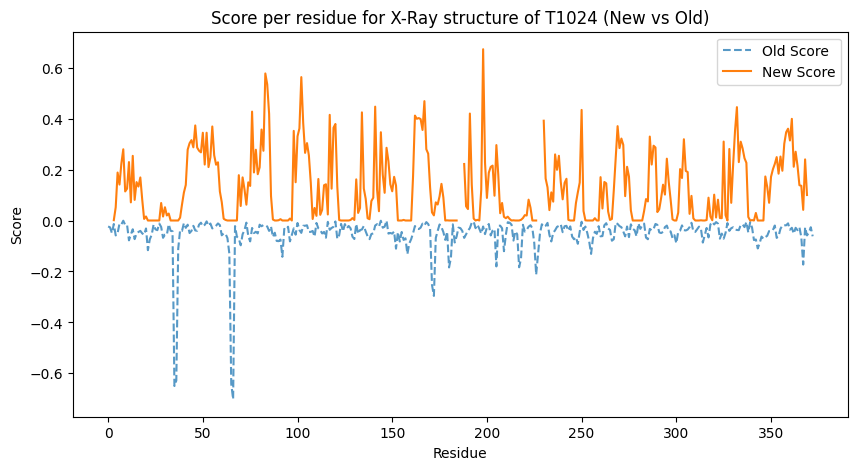

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(len(da.xray_phi_psi)), -da.xray_phi_psi.da/255, label='Old Score', linestyle='--', alpha=0.75)
ax.plot(np.arange(len(da.xray_phi_psi)), da.xray_phi_psi.new_score, label='New Score')
ax.legend()
ax.set_title(f'Score per residue for X-Ray structure of {da.casp_protein_id} (New vs Old)')
ax.set_xlabel('Residue')
ax.set_ylabel('Score')
plt.show()

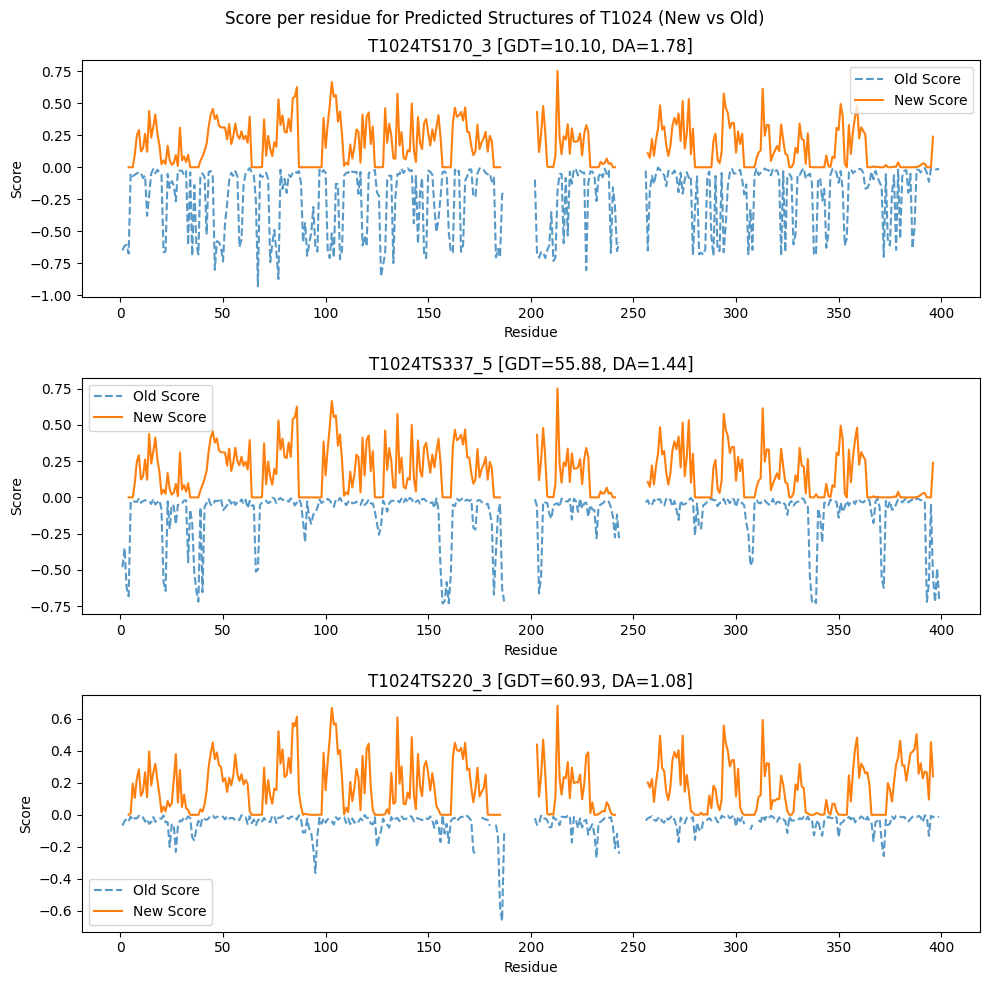

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
proteins = ['T1024TS170_3', 'T1024TS337_5', 'T1024TS220_3']
for protein,ax in zip(proteins,axes):
    preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == protein]
    pred_gdt = da.grouped_preds.loc[da.grouped_preds.protein_id == protein, 'GDT_TS'].iloc[0]
    pred_da = da.grouped_preds.loc[da.grouped_preds.protein_id == protein, 'log_da'].iloc[0]
    ax.plot(np.arange(len(preds)), -preds.da/255, label='Old Score', linestyle='--', alpha=0.75)
    ax.plot(np.arange(len(preds)), preds.new_score, label='New Score')
    ax.legend()
    ax.set_title(f'{protein} [GDT={pred_gdt:.2f}, DA={pred_da:.2f}]')
    ax.set_xlabel('Residue')
    ax.set_ylabel('Score')
fig.suptitle(f'Score per residue for Predicted Structures of {da.casp_protein_id} (New vs Old)')
plt.tight_layout()
plt.show()

<Axes: >

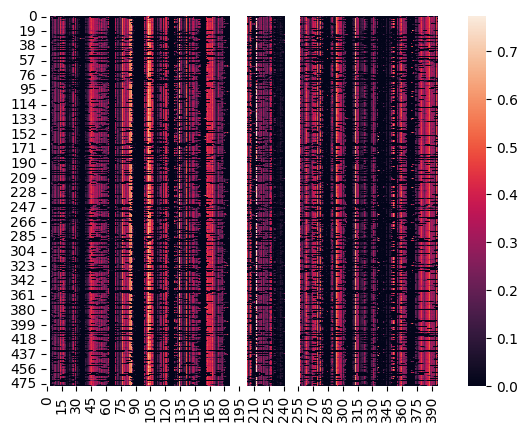

In [32]:
sns.heatmap(da.phi_psi_predictions[['protein_id', 'pos', 'new_score']].pivot(index='protein_id', columns='pos', values='new_score').values)

In [37]:
da.phi_psi_predictions

,pos,seq_ctxt,res,phi,psi,protein_id,conf_x,da,n_samples,n_samples_list,da_no_scale,conf_y,da_na,new_score,conf
0,3,MKEFWNL,F,-78.052774,146.327940,T1024TS337_5,91.75,NaN,NaN,NaN,NaN,91.75,True,NaN,91.75
1,4,KEFWNLD,W,-97.031635,105.226367,T1024TS337_5,92.25,122.937445,413.0,"[388, 25, 0, 0]",122.937445,92.25,True,NaN,92.25
2,5,EFWNLDK,N,-92.098690,90.354044,T1024TS337_5,94.00,89.119237,299.0,"[291, 8, 0, 0]",89.119237,94.00,True,NaN,94.00
3,6,FWNLDKN,L,-66.444048,-46.680296,T1024TS337_5,96.00,158.702488,2592.0,"[2550, 42, 0, 0]",158.702488,96.00,True,NaN,96.00
4,7,WNLDKNL,D,-73.624553,-41.143020,T1024TS337_5,97.25,174.206356,2530.0,"[2427, 95, 8, 0]",174.206356,97.25,False,0.0,97.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192151,400,AVNRHQK,R,-68.818207,-32.215532,T1024TS341_2,96.44,8.842355,134.0,"[134, 0, 0, 0]",8.842355,96.44,True,NaN,96.44
192152,401,VNRHQKT,H,-59.005171,-47.592129,T1024TS341_2,94.25,9.359761,446.0,"[446, 0, 0, 0]",9.359761,94.25,True,NaN,94.25
192153,402,NRHQKTK,Q,-59.143012,113.612199,T1024TS341_2,91.69,151.239288,531.0,"[512, 19, 0, 0]",151.239288,91.69,True,NaN,91.69
192154,403,RHQKTKL,K,-136.886969,131.962334,T1024TS341_2,90.69,NaN,NaN,NaN,NaN,90.69,True,NaN,90.69


(478, 5)


<Axes: xlabel='new_score', ylabel='GDT_TS'>

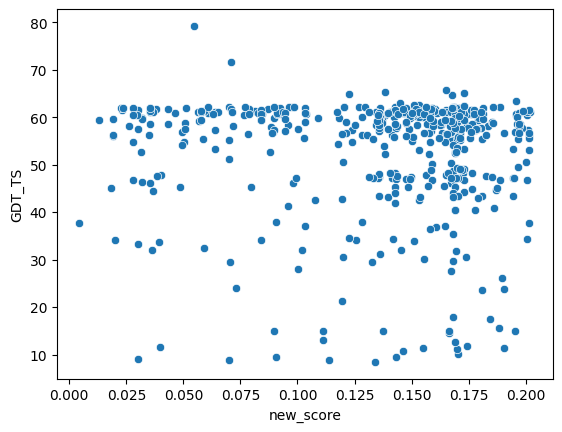

In [41]:
# worst xray ones
da.phi_psi_predictions.da_na = da.phi_psi_predictions.new_score.isna()
grouped_preds = da.phi_psi_predictions.groupby('protein_id').new_score.mean().to_frame('new_score')
grouped_preds['da_na'] = da.phi_psi_predictions[['protein_id', 'da_na']].groupby('protein_id').mean()
grouped_preds = pd.merge(
    grouped_preds.reset_index(),
    da.results[['Model', 'GDT_TS']],
    left_on='protein_id',
    right_on='Model',
    how='inner'
)
print(grouped_preds.shape)
# grouped_preds = grouped_preds[grouped_preds.da_na < grouped_preds.da_na.quantile(0.8)]
sns.scatterplot(x=grouped_preds.new_score, y=grouped_preds.GDT_TS)

In [75]:
da.xray_phi_psi[da.xray_phi_psi.new_score == 0.0].shape[0] / da.xray_phi_psi.shape[0]

0.21447721179624665

In [43]:
da.xray_phi_psi.sort_values('new_score').head(10)

,pos,seq_ctxt,res,phi,psi,protein_id,da,n_samples,n_samples_list,da_no_scale,new_score
215,226,IMQFDNF,F,-55.638257,-35.101299,6t1z,10.919220,441.0,"[436, 5, 0, 0]",10.919220,0.0
126,130,DASNAEN,N,-111.834049,161.721426,6t1z,7.850945,1639.0,"[1424, 207, 8, 0]",7.850945,0.0
125,129,IDASNAE,S,-117.293290,150.571744,6t1z,3.591201,1753.0,"[1689, 62, 2, 0]",3.591201,0.0
124,128,IIDASNA,A,-97.885197,12.489673,6t1z,10.786237,1782.0,"[1610, 172, 0, 0]",10.786237,0.0
123,127,MIIDASN,D,-60.453817,-43.104190,6t1z,3.352345,2669.0,"[2556, 111, 2, 0]",3.352345,0.0
226,237,LSNSFKT,S,-144.888539,52.246372,6t1z,54.070270,939.0,"[900, 39, 0, 0]",54.070270,0.0
225,236,HLSNSFK,N,-71.728560,-43.737810,6t1z,22.634904,1312.0,"[1063, 249, 0, 0]",22.634904,0.0
224,235,VHLSNSF,S,-59.647015,-42.570286,6t1z,7.769309,3077.0,"[3064, 13, 0, 0]",7.769309,0.0
217,228,QFDNFLP,N,-114.747501,-44.150063,6t1z,46.801833,2199.0,"[2110, 76, 13, 0]",46.801833,0.0
216,227,MQFDNFL,D,-75.645350,-38.799103,6t1z,13.787032,774.0,"[754, 20, 0, 0]",13.787032,0.0


DASNAEN
1424


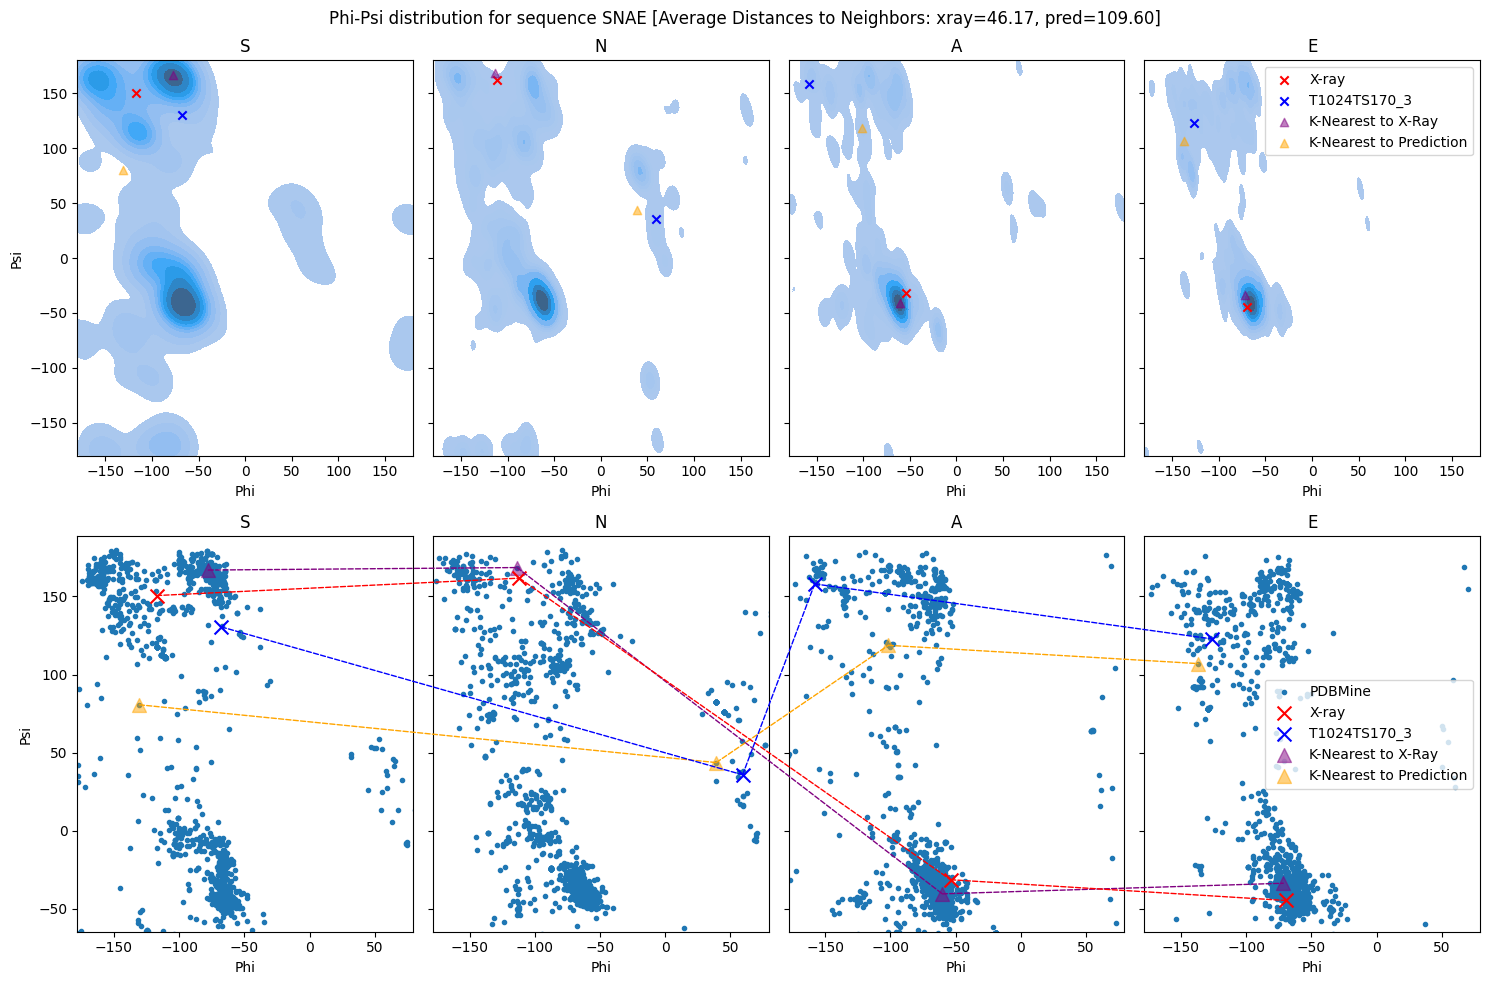

In [72]:
xrays, preds, nearest, pred_nearest, distances, pred_distances = \
    plot(da, da.queries[0], 'DASNAEN', da.protein_ids[2], 1)

In [71]:
def diff(x1, x2):
    d = np.abs(x1 - x2)
    return np.minimum(d, 360-d)

np.sqrt((diff(xrays[['phi', 'psi']].values, pred_nearest[0])**2).sum())

53.48729460005756